### House Prices - Advanced Regression Techniques
#### Predict sales prices and practice feature engineering, RFs, and gradient boosting

#### When most home buyers are asked to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

#### With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this project requires the prediction of the final price of each home.

### Import required modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor
from sklearn.linear_model import ARDRegression, LassoCV, LinearRegression,RANSACRegressor, Ridge,BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor,RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [3]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [4]:
import warnings
warnings.filterwarnings('ignore')

### Import the train and test data

In [5]:
train_df = pd.read_csv('Regression/train.csv')

In [6]:
test_df = pd.read_csv('Regression/test.csv')

### Read the Data

In [7]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Saleprice is the dependent variable y while other variables are independent variables

### Let us check out the data to see if there are null values and calculate the percentage of null values for each variable

In [8]:
def null_values(df):
    total_null = df.isnull().sum().sort_values(ascending = False)
    count_null = df.isnull().count().sort_values(ascending = False)
    percent_null = round(total_null/count_null * 100,2)
    missing_df = pd.concat([total_null, percent_null], axis = 1, keys=['Total','Percent'])
    return missing_df

In [9]:
null_df = null_values(train_df)

In [10]:
null_df[null_df['Percent'] >= 20]

,Total,Percent
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26


### PoolQC, MiscFeature, Alley, Fence and FireplaceQu has high percentage of missing values so we drop them

In [11]:
train_df.drop(['PoolQC','MiscFeature','Alley','Fence','Fence'], axis = 1, inplace = True)
test_df.drop(['PoolQC','MiscFeature','Alley','Fence','Fence'], axis = 1, inplace = True)

### Fill the missing values of the numeric variables with the median for both test and train data.

In [12]:
median_train = train_df.median()
median_test = test_df.median()

In [13]:
train_df.fillna(train_df.median(), inplace = True)
test_df.fillna(test_df.median(), inplace = True)

In [14]:
null_values(train_df)

,Total,Percent
FireplaceQu,690,47.26
GarageCond,81,5.55
GarageType,81,5.55
GarageFinish,81,5.55
GarageQual,81,5.55
...,...,...
BsmtFinSF2,0,0.00
BsmtUnfSF,0,0.00
TotalBsmtSF,0,0.00
MSSubClass,0,0.00


In [15]:
train_df.fillna(method = 'bfill', inplace = True)
test_df.fillna(method = 'bfill', inplace = True)

In [16]:
null_values(train_df)

,Total,Percent
FireplaceQu,2,0.14
Id,0,0.00
HalfBath,0,0.00
Fireplaces,0,0.00
Functional,0,0.00
...,...,...
MasVnrArea,0,0.00
MasVnrType,0,0.00
Exterior2nd,0,0.00
Exterior1st,0,0.00


In [17]:
train_df = train_df.dropna()

In [18]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [20]:
train_df['SalePrice_log'] = np.log(train_df['SalePrice'])

In [64]:
train_df_copy = train_df.copy()

### Separate the dependent variable from the independent variable. The dependent variable y is SalePrice

In [22]:
X = train_df.drop(['SalePrice','SalePrice_log'],axis = 1)
Y = train_df['SalePrice_log']

### Encode the string variables that are categorical for both train and test data

In [23]:
# Label encoding for categoricals for train_df data
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [24]:
# Label encoding for categoricals for test data
for colname in test_df.select_dtypes("object"):
    test_df[colname], _ = test_df[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = test_df.dtypes == int

In [25]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,0,80.0,11622,0,0,0,0,0,...,0,0,0,120,0,0,6,2010,0,0
1,1462,20,1,81.0,14267,0,1,0,0,1,...,36,0,0,0,0,12500,6,2010,0,0
2,1463,60,1,74.0,13830,0,1,0,0,0,...,34,0,0,0,0,0,3,2010,0,0
3,1464,60,1,78.0,9978,0,1,0,0,0,...,36,0,0,0,0,0,6,2010,0,0
4,1465,120,1,43.0,5005,0,1,1,0,0,...,82,0,0,144,0,0,1,2010,0,0


#### Creating mutual information scores to determine the correlation of the independent variable with the dependent variable

In [26]:
def make_mi_scores(X, Y, discrete_features):
    mi_scores = mutual_info_regression(X, Y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, Y, discrete_features)
mi_scores[::3]

OverallQual      0.574521
GarageCars       0.368089
TotalBsmtSF      0.359982
1stFlrSF         0.298342
MSSubClass       0.274838
LotFrontage      0.216874
Foundation       0.196482
HeatingQC        0.167394
OpenPorchSF      0.157271
BsmtFinType1     0.137841
Exterior1st      0.125255
WoodDeckSF       0.101022
LotShape         0.084189
SaleCondition    0.077440
Electrical       0.051733
BsmtExposure     0.045784
Condition1       0.026159
EnclosedPorch    0.024870
ScreenPorch      0.020354
Heating          0.014211
RoofStyle        0.008027
RoofMatl         0.005314
BsmtFinType2     0.002609
Street           0.000705
LandSlope        0.000000
Id               0.000000
Name: MI Scores, dtype: float64

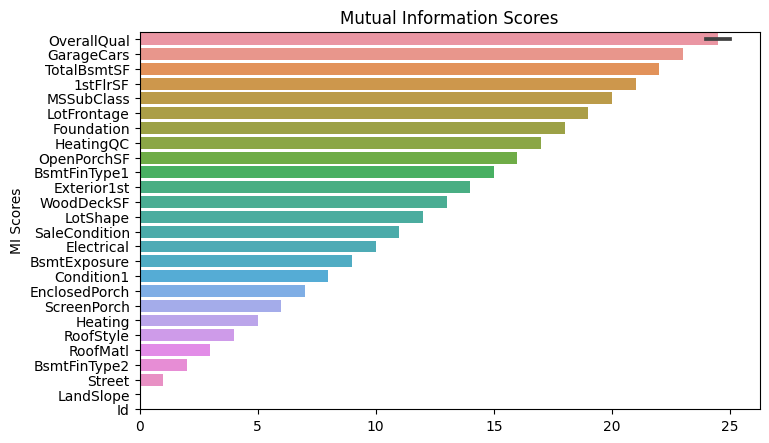

In [27]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=False)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    sns.barplot(width, scores, orient='h')
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores[::3])

- The barplot above shows the features with 24 most correlation with the dependent variable.
- We can create a heatmap to see whether these features are independent of each other or there is multicollinearity

In [28]:
mi_features = pd.DataFrame(mi_scores[::3]).reset_index().rename(columns = {'index':'Features'}).head(20)

In [29]:
mi_features

,Features,MI Scores
0,OverallQual,0.574521
1,GarageCars,0.368089
2,TotalBsmtSF,0.359982
3,1stFlrSF,0.298342
4,MSSubClass,0.274838
5,LotFrontage,0.216874
6,Foundation,0.196482
7,HeatingQC,0.167394
8,OpenPorchSF,0.157271
9,BsmtFinType1,0.137841


### Extract these features from the train data to check for mutilcollinearity

In [30]:
train_df_extract = train_df.filter(mi_features['Features'])

In [42]:
# Label encoding for categoricals for train_df data
for colname in train_df_extract.select_dtypes("object"):
    train_df_extract[colname], _ = train_df_extract[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = train_df_extract.dtypes == int

In [43]:
train_df_extract.head()

,OverallQual,GarageCars,TotalBsmtSF,1stFlrSF,MSSubClass,LotFrontage,Foundation,HeatingQC,OpenPorchSF,BsmtFinType1,...,WoodDeckSF,LotShape,SaleCondition,Electrical,BsmtExposure,Condition1,EnclosedPorch,ScreenPorch,Heating,SalePrice_log
0,7,2,856,856,60,65.0,0,0,61,0,...,0,0,0,0,0,0,0,0,0,12.247694
1,6,2,1262,1262,20,80.0,1,0,0,1,...,298,0,0,0,1,1,0,0,0,12.109011
2,7,2,920,920,60,68.0,0,0,42,0,...,0,1,0,0,2,0,0,0,0,12.317167
3,7,3,756,961,70,60.0,2,1,35,1,...,0,1,1,0,0,0,272,0,0,11.849398
4,8,3,1145,1145,60,84.0,0,0,84,0,...,192,1,0,0,3,0,0,0,0,12.429216


- Univariate analysis
- let us check the distribution of the extracted variables

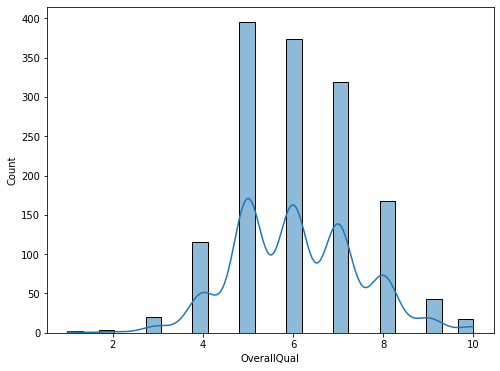

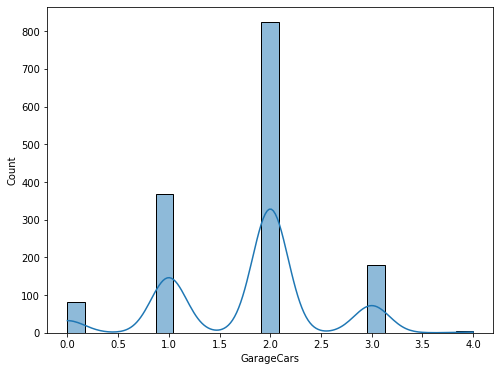

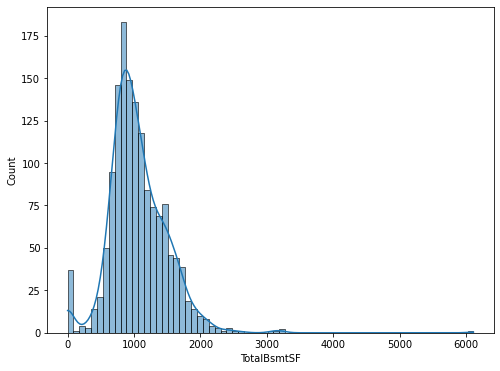

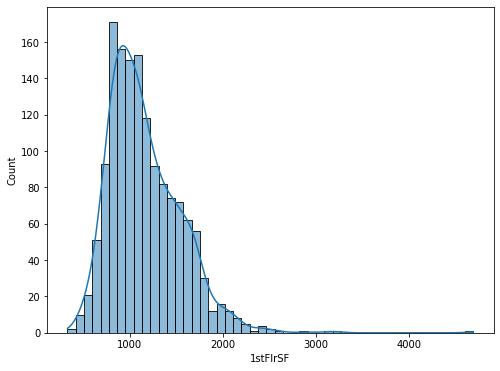

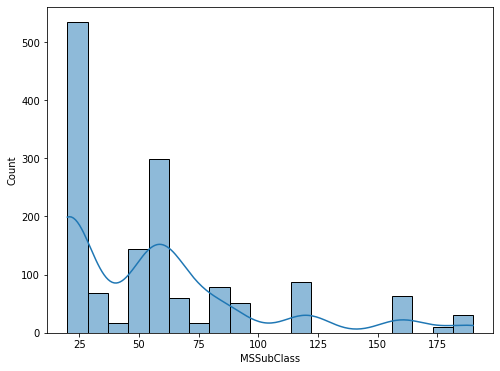

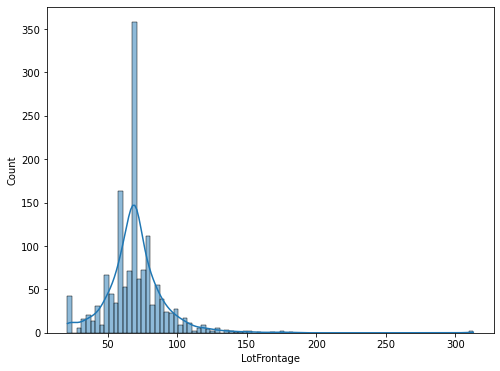

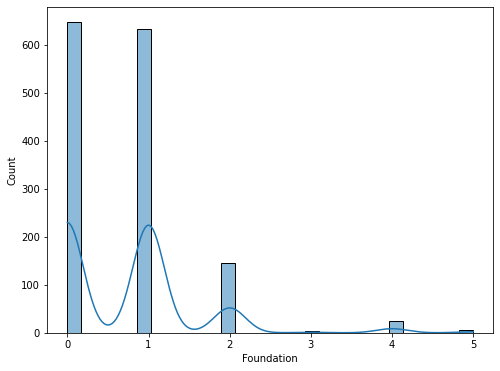

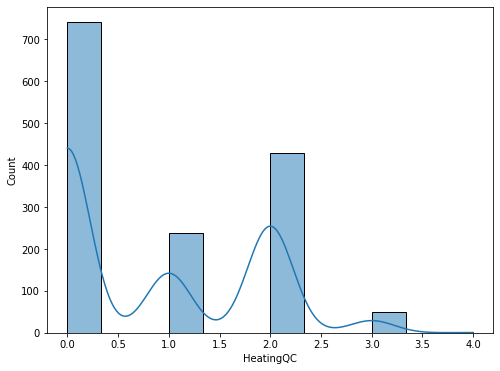

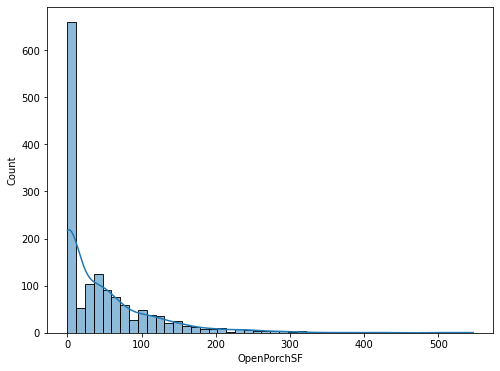

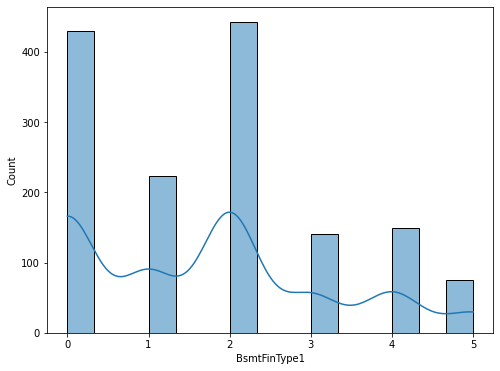

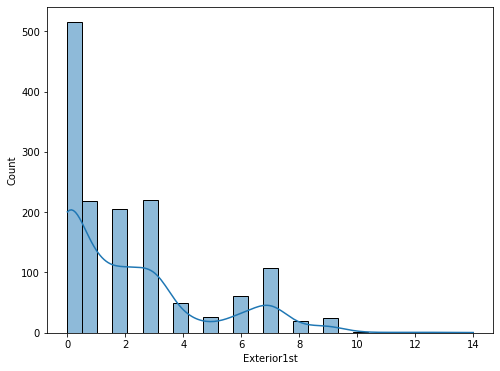

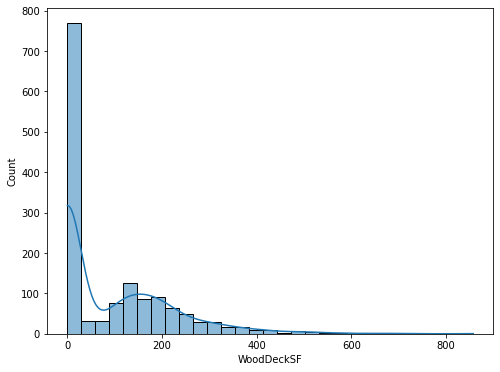

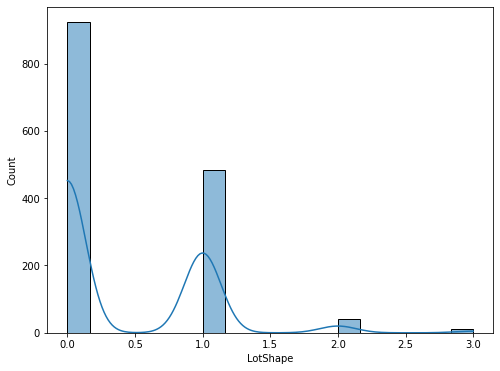

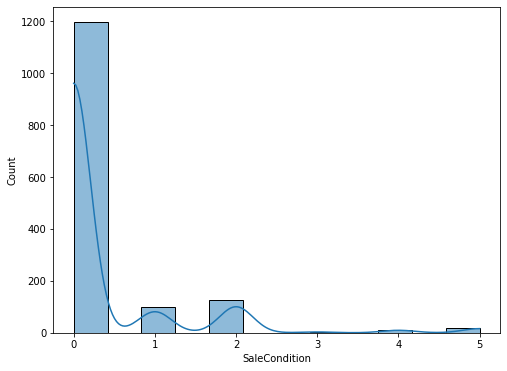

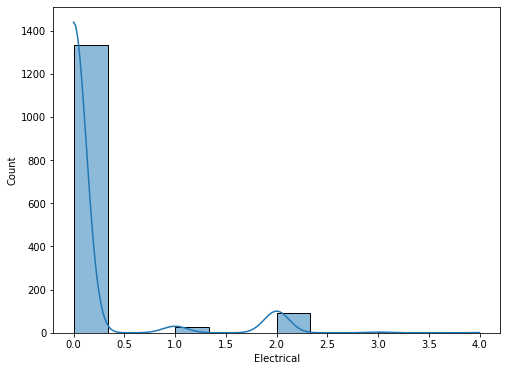

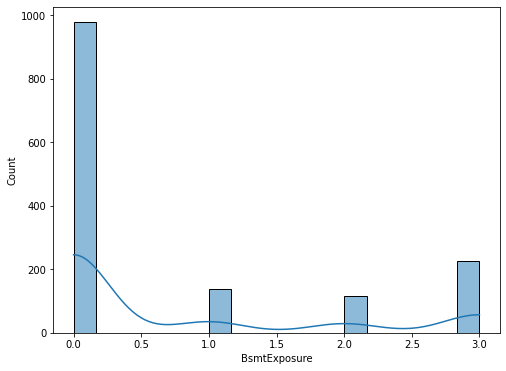

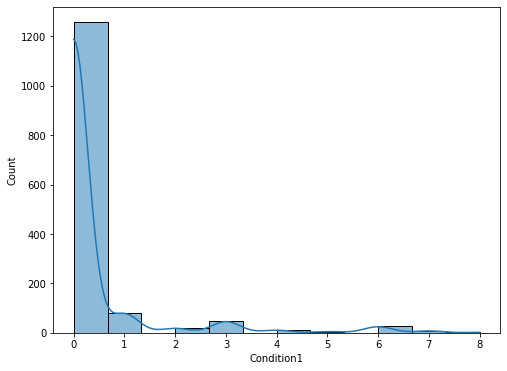

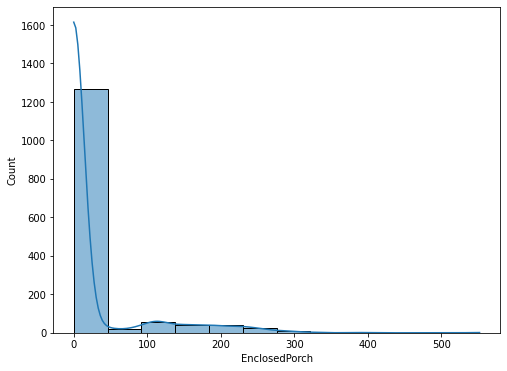

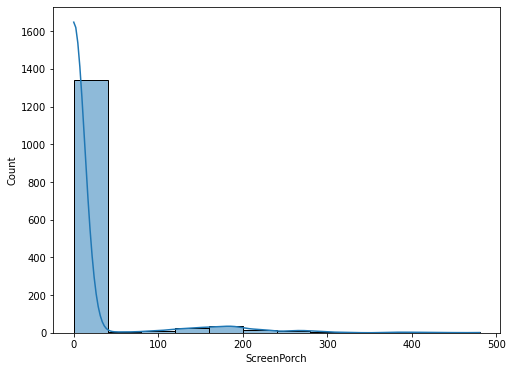

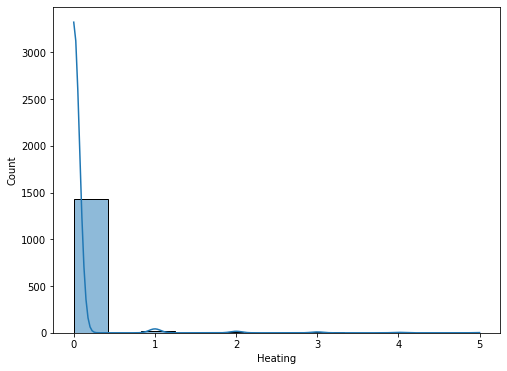

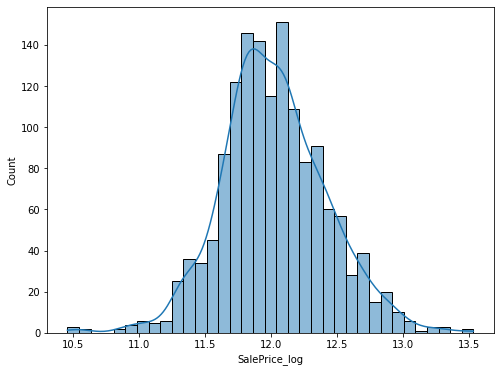

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

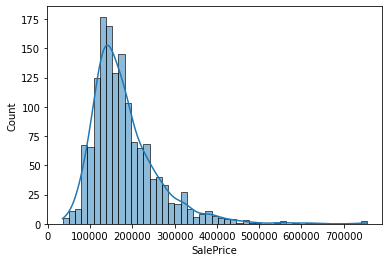

In [44]:
for i in train_df_extract.columns:
    plt.figure(figsize=(8,6))
    sns.histplot(data = train_df_extract, x = i, kde = True)
    plt.show()

sns.histplot(data = train_df, x = 'SalePrice', kde = True)

### The SalePrice is a right-skewed and there is need to make it more normally distributed

<AxesSubplot:xlabel='SalePrice_log', ylabel='Count'>

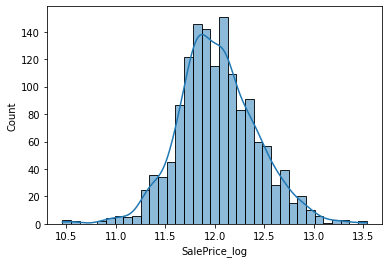

In [45]:

sns.histplot(data = train_df_extract, x = 'SalePrice_log', kde = True)

### Taking the logarithmic value of Saleprice make it more normally distributed

In [46]:
train_df_extract

,OverallQual,GarageCars,TotalBsmtSF,1stFlrSF,MSSubClass,LotFrontage,Foundation,HeatingQC,OpenPorchSF,BsmtFinType1,...,WoodDeckSF,LotShape,SaleCondition,Electrical,BsmtExposure,Condition1,EnclosedPorch,ScreenPorch,Heating,SalePrice_log
0,7,2,856,856,60,65.0,0,0,61,0,...,0,0,0,0,0,0,0,0,0,12.247694
1,6,2,1262,1262,20,80.0,1,0,0,1,...,298,0,0,0,1,1,0,0,0,12.109011
2,7,2,920,920,60,68.0,0,0,42,0,...,0,1,0,0,2,0,0,0,0,12.317167
3,7,3,756,961,70,60.0,2,1,35,1,...,0,1,1,0,0,0,272,0,0,11.849398
4,8,3,1145,1145,60,84.0,0,0,84,0,...,192,1,0,0,3,0,0,0,0,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,5,0,1140,1140,20,90.0,0,0,56,2,...,36,0,1,0,0,0,0,0,0,11.344507
1454,7,2,1221,1221,20,62.0,0,0,113,0,...,0,0,0,0,0,0,0,0,0,12.128111
1455,6,2,953,953,60,62.0,0,0,40,2,...,0,0,0,0,0,0,0,0,0,12.072541
1456,6,2,1542,2073,20,85.0,1,2,0,1,...,349,0,0,0,0,0,0,0,0,12.254863


#### Create the heatmap

<AxesSubplot:>

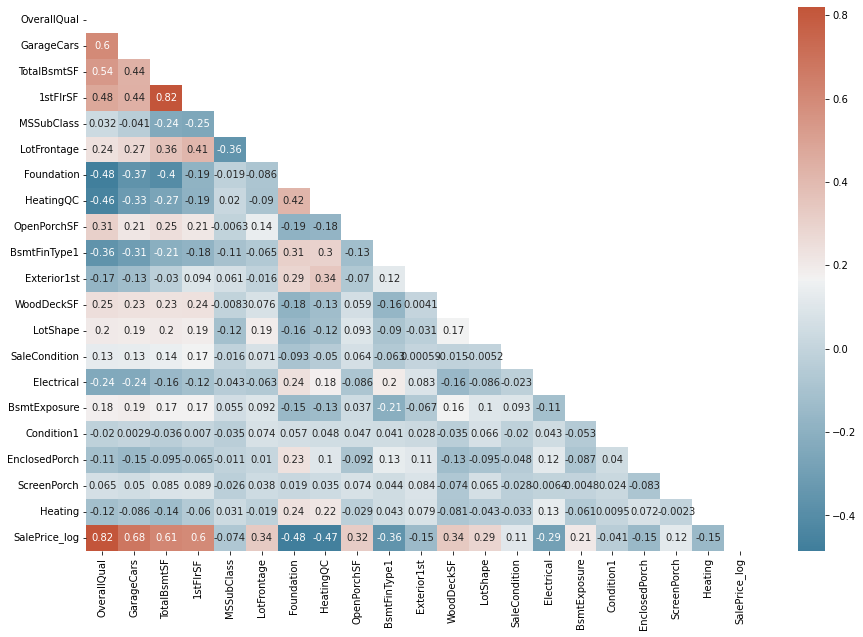

In [47]:
plt.figure(figsize=(15,10))
matrix = np.triu(train_df_extract.corr())
cmap=sns.diverging_palette(230,20, as_cmap=True)
sns.heatmap(train_df_extract.corr(), annot=True, mask=matrix, cmap=cmap)

In [48]:
X = train_df_extract.drop('SalePrice_log', axis = 1)
Y = train_df_extract['SalePrice_log']

X1 = X.copy()
Y1 = Y.copy()

### Check for Multicollinearity
- Multicollinearity occurs when predictor variables in a regression model are correlated. This correlation is a problem because predictor variables should be independent. If the correlation between variables is high, it can cause problems when we fit the model and interpret the results. When we have multicollinearity in the linear model, the coefficients that the model suggests are unreliable.

- There are different ways of detecting (or testing) multi-collinearity, one such way is the Variation Inflation Factor.

- Variance Inflation factor: Variance inflation factors measures the inflation in the variances of the regression parameter estimates due to collinearity that exists among the predictors. It is a measure of how much the variance of the estimated regression coefficient βk is "inflated" by the existence of correlation among the predictor variables in the model.

- General Rule of thumb: If VIF is 1 then there is no correlation between the kth predictor and the remaining predictor variables, and hence the variance of β̂k is not inflated at all. Whereas if VIF exceeds 5 or is close to exceeding 5, we say there is moderate VIF and if it is 10 or exceeding 10, it shows signs of high multi-collinearity.

In [49]:
#Calculating the variance inflation factor for each variable. We remove any variable with VIF greater than 5

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [50]:
# Function to check VIF
def checking_vif(train):
    vif = pd.DataFrame()
    vif["feature"] = train.columns

    # Calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(train.values, i) for i in range(len(train.columns))
    ]
    return vif


print(checking_vif(X))

          feature        VIF
0     OverallQual  29.504763
1      GarageCars  11.593515
2     TotalBsmtSF  27.000360
3        1stFlrSF  38.477545
4      MSSubClass   3.233740
5     LotFrontage  13.463765
6      Foundation   2.909524
7       HeatingQC   2.522098
8     OpenPorchSF   1.689023
9    BsmtFinType1   2.670651
10    Exterior1st   2.232852
11     WoodDeckSF   1.833070
12       LotShape   1.663015
13  SaleCondition   1.215867
14     Electrical   1.212537
15   BsmtExposure   1.551167
16     Condition1   1.132242
17  EnclosedPorch   1.246597
18    ScreenPorch   1.127250
19        Heating   1.115339


### Let us remove the feature with the highest VIF 1stFlrSF and recalculate the VIF

In [51]:
X.drop(columns={'1stFlrSF','OverallQual','TotalBsmtSF'}, axis = 1, inplace = True)

#check VIF again
print(checking_vif(X))

          feature       VIF
0      GarageCars  7.711633
1      MSSubClass  2.466719
2     LotFrontage  8.937814
3      Foundation  2.547767
4       HeatingQC  2.506533
5     OpenPorchSF  1.632861
6    BsmtFinType1  2.616858
7     Exterior1st  2.124014
8      WoodDeckSF  1.774441
9        LotShape  1.655594
10  SaleCondition  1.199093
11     Electrical  1.209719
12   BsmtExposure  1.538931
13     Condition1  1.127148
14  EnclosedPorch  1.238601
15    ScreenPorch  1.120855
16        Heating  1.111064


In [52]:
# Add the intercept term
X= sm.add_constant(X)

Split data into train and test data

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=42)

In [54]:
X_train.shape, y_train.shape

((1020, 18), (1020,))

Now, we will create the linear regression model as the VIF is less than 5 for all the independent variables, and we can assume that multicollinearity has been removed between the variables.

Preporcess the data

In [55]:
scale = MinMaxScaler()

In [56]:

X_train_scaled=pd.DataFrame(scale.fit_transform(X_train), columns=X_train.columns)

X_train_scaled.head()

,const,GarageCars,MSSubClass,LotFrontage,Foundation,HeatingQC,OpenPorchSF,BsmtFinType1,Exterior1st,WoodDeckSF,LotShape,SaleCondition,Electrical,BsmtExposure,Condition1,EnclosedPorch,ScreenPorch,Heating
0,0.0,0.50,0.000000,0.202055,0.0,0.25,0.000000,0.4,0.500000,0.114352,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.0
1,0.0,0.00,0.411765,0.133562,0.2,0.50,0.082267,0.4,0.000000,0.037340,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.0
2,0.0,0.75,0.235294,0.219178,0.0,0.00,0.197441,0.0,0.428571,0.249708,0.333333,0.4,0.0,1.000000,0.00,0.0,0.0,0.0
3,0.0,0.75,0.235294,0.284247,0.0,0.00,0.091408,0.0,0.214286,0.445741,0.333333,0.0,0.0,0.333333,0.00,0.0,0.0,0.0
4,0.0,0.50,0.235294,0.075342,0.0,0.00,0.111517,0.0,0.000000,0.184364,0.666667,0.0,0.0,1.000000,0.25,0.0,0.0,0.0


In [57]:
X_train_scaled.shape ,y_train.shape

((1020, 18), (1020,))

### **Creating linear regression model using statsmodels OLS**

In [58]:
# Create the model
model1 = sm.OLS(y_train, X_train).fit()

# Get the model summary
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     106.5
Date:                Mon, 29 Aug 2022   Prob (F-statistic):          1.46e-210
Time:                        22:40:43   Log-Likelihood:                 36.650
No. Observations:                1020   AIC:                            -37.30
Df Residuals:                    1002   BIC:                             51.40
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            11.5074      0.040    285.734      0.000      11.428      11.586
GarageCars        0.2270      0.012     19.375      0.000       0.204       0.250
MSSubClass    -1.285e-05      0.000     -0.067      0.947      -0.000       0.000
LotFrontage       0.0022      0.000      5.565      0.000       0.001       0.003
Foundation       -0.0602      0.011     -5.736      0.000      -0.081      -0.040
HeatingQC        -0.0875      0.009     -9.524      0.000      -0.105      -0.069
OpenPorchSF       0.0005      0.000      4.642      0.000       0.000       0.001
BsmtFinType1     -0.0177      0.006     -3.138      0.002      -0.029      -0.007
Exterior1st       0.0046      0.003      1.399      0.162      -0.002       0.011
WoodDeckSF        0.0004   6.31e-05      6.824      0.000       0.000       0.001
LotShape          0.0599      0.013      4.481      0.000       0.034       0.086
SaleCondition     0.0101      0.008      1.229      0.219      -0.006       0.026
Electrical       -0.0393      0.015     -2.538      0.011      -0.070      -0.009
BsmtExposure      0.0079      0.007      1.159      0.247      -0.006       0.021
Condition1       -0.0122      0.006     -1.952      0.051      -0.025    6.74e-05
EnclosedPorch     0.0001      0.000      0.969      0.333      -0.000       0.000
ScreenPorch       0.0007      0.000      5.045      0.000       0.000       0.001
Heating           0.0387      0.030      1.289      0.198      -0.020       0.098
==============================================================================
Omnibus:                       49.727   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.911
Skew:                          -0.043   Prob(JB):                     4.21e-36
Kurtosis:                       4.956   Cond. No.                         960.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If P>|t| ia less than 0.05, the variable is significant

Drop the columns with pvalues greater than 0.05 and run the model again

In [59]:
X = X.drop(columns = {'EnclosedPorch','BsmtExposure','Exterior1st','MSSubClass','SaleCondition','Heating'})
X = sm.add_constant(X)

# Splitting the data in 70:30 ratio of train to test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30 , random_state = 1)

# Create the model
model2 = sm.OLS(y_train, X_train).fit()

# Get the model summary
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     169.2
Date:                Mon, 29 Aug 2022   Prob (F-statistic):          4.81e-220
Time:                        22:41:55   Log-Likelihood:                 26.513
No. Observations:                1020   AIC:                            -29.03
Df Residuals:                    1008   BIC:                             30.10
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           11.5123      0.034    342.797      0.000      11.446      11.578
GarageCars       0.2293      0.012     18.994      0.000       0.206       0.253
LotFrontage      0.0021      0.000      6.126      0.000       0.001       0.003
Foundation      -0.0654      0.011     -5.974      0.000      -0.087      -0.044
HeatingQC       -0.0799      0.009     -9.060      0.000      -0.097      -0.063
OpenPorchSF      0.0007      0.000      6.068      0.000       0.000       0.001
BsmtFinType1    -0.0185      0.005     -3.401      0.001      -0.029      -0.008
WoodDeckSF       0.0005   6.43e-05      7.439      0.000       0.000       0.001
LotShape         0.0660      0.014      4.862      0.000       0.039       0.093
Electrical      -0.0336      0.015     -2.245      0.025      -0.063      -0.004
Condition1      -0.0108      0.006     -1.859      0.063      -0.022       0.001
ScreenPorch      0.0008      0.000      5.864      0.000       0.001       0.001
==============================================================================
Omnibus:                       57.493   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.846
Skew:                          -0.051   Prob(JB):                     9.96e-47
Kurtosis:                       5.230   Cond. No.                         768.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- We can see that the `R-squared` for the model is `0.65`. 
- Not all the variables are statistically significant to predict the outcome variable. To check which are statistically significant or have predictive power to predict the target variable, we need to check the `p-value` against all the independent variables.

**Interpreting the Regression Results:**

1. **Adjusted. R-squared**: It reflects the fit of the model.
    - R-squared values range from 0 to 1, where a higher value generally indicates a better fit, assuming certain conditions are met.
    - In our case, the value for Adj. R-squared is **0.645**

#### **Applying the cross validation technique to improve the model and evaluating it using different evaluation metrics.**

In [60]:
# Import the required function

from sklearn.model_selection import cross_val_score

# Build the regression model using Sklearn Linear regression
linearregression = LinearRegression()                                    

cv_Score11 = cross_val_score(linearregression, X_train, y_train, cv = 10) # cv = 10 represents data is divided into 10 folds.
cv_Score12 = cross_val_score(linearregression, X_train, y_train, cv = 10, 
                             scoring = 'neg_mean_squared_error')                                  


print("RSquared: %0.3f (+/- %0.3f)" % (cv_Score11.mean(), cv_Score11.std() * 2))
print("Mean Squared Error: %0.3f (+/- %0.3f)" % (-1*cv_Score12.mean(), cv_Score12.std() * 2))

RSquared: 0.627 (+/- 0.112)
Mean Squared Error: 0.058 (+/- 0.026)


Observations:

The R-squared on the cross-validation is 0.65, whereas on the training dataset it was 0.627
And the MSE on cross-validation is 0.058

Get model Coefficients in a pandas dataframe with column 'Feature' having all the features and column 'Coefs' with all the corresponding Coefs. Write the regression equation.

In [61]:
coef = model2.params
coef

const           11.512302
GarageCars       0.229283
LotFrontage      0.002131
Foundation      -0.065359
HeatingQC       -0.079942
OpenPorchSF      0.000708
BsmtFinType1    -0.018505
WoodDeckSF       0.000478
LotShape         0.065960
Electrical      -0.033569
Condition1      -0.010803
ScreenPorch      0.000807
dtype: float64

## RandomForestRegressor

In [62]:
# Defining the Random forest regressor
rf = RandomForestRegressor(n_estimators = 200, max_depth = 4, min_samples_split = 2)

In [65]:
X1 = train_df_copy.drop(['SalePrice','SalePrice_log'],axis = 1)
Y1 = train_df_copy['SalePrice_log']

In [66]:
# Label encoding for categoricals
for colname in X1.select_dtypes("object"):
    X1[colname], _ = X1[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X1.dtypes == int

In [67]:
X1.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,0,65.0,8450,0,0,0,0,0,...,61,0,0,0,0,0,2,2008,0,0
1,2,20,0,80.0,9600,0,0,0,0,1,...,0,0,0,0,0,0,5,2007,0,0
2,3,60,0,68.0,11250,0,1,0,0,0,...,42,0,0,0,0,0,9,2008,0,0
3,4,70,0,60.0,9550,0,1,0,0,2,...,35,272,0,0,0,0,2,2006,0,1
4,5,60,0,84.0,14260,0,1,0,0,1,...,84,0,0,0,0,0,12,2008,0,0


In [68]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size = 0.30 , random_state = 1)

In [69]:
# Hyperparameters, we have randomly choosen them for now but we can tune these hyperparameters and get the best model. 

# Fitting the model
rf.fit(X_train1,y_train1)

RandomForestRegressor(max_depth=4, n_estimators=200)

In [70]:
X_train1.shape, X_test1.shape

((1020, 76), (438, 76))

In [71]:
rf.score(X_train1,y_train1)

0.8581037331559456

#### Check the performance of the model on train and test data

In [72]:
# RMSE
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())


# MAPE
def mape(predictions, targets):
    return np.mean(np.abs((targets - predictions)) / targets) * 100


# MAE
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))


# Model Performance on test and train data
def model_pref(olsmodel, x_train, x_test, y_train, y_test):

    # Insample Prediction
    y_pred_train = olsmodel.predict(x_train)
    y_observed_train = y_train

    # Prediction on test data
    y_pred_test = olsmodel.predict(x_test)
    y_observed_test = y_test

    print(
        pd.DataFrame(
            {
                "Data": ["Train", "Test"],
                "RMSE": [
                    rmse(y_pred_train, y_observed_train),
                    rmse(y_pred_test, y_observed_test),
                ],
                "MAE": [
                    mae(y_pred_train, y_observed_train),
                    mae(y_pred_test, y_observed_test),
                ],
                "MAPE": [
                    mape(y_pred_train, y_observed_train),
                    mape(y_pred_test, y_observed_test),
                ],
            }
        )
    )


# Checking model performance
model_pref(model2, X_train, X_test, y_train, y_test)  

    Data      RMSE       MAE      MAPE
0  Train  0.235762  0.174464  1.451973
1   Test  0.234253  0.178638  1.492572


In [73]:
model_pref(rf, X_train1, X_test1, y_train1, y_test1)  

    Data      RMSE       MAE      MAPE
0  Train  0.149820  0.108989  0.910200
1   Test  0.176348  0.124631  1.046343


**Observations:**

* RMSE, MAE, and MAPE of train and test data are not very different, indicating that the **model is not overfitting and has generalized well.**

#### Important features derviced from RandomForestRegressor

In [74]:
importances = rf.feature_importances_
columns = X1.columns
importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)
importance_df.head()

,Importance
OverallQual,0.617515
GrLivArea,0.135080
TotalBsmtSF,0.057364
GarageArea,0.039098
GarageCars,0.037767


In [75]:
importance_df = importance_df.reset_index().rename(columns={'index':'Features'})

In [76]:
#Select top q0 features according to their importance
importance_df_10 = importance_df.head(10)

<AxesSubplot:xlabel='Importance', ylabel='Features'>

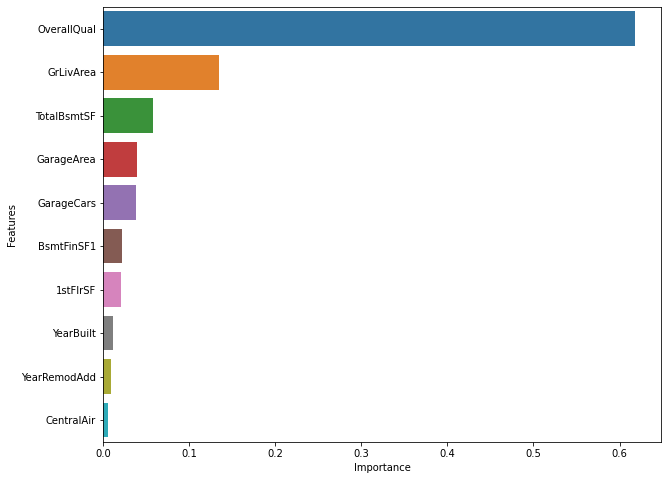

In [77]:
plt.figure(figsize = (10,8))
sns.barplot(importance_df_10.Importance, importance_df_10.Features)

### Test the model on the test data test_df

In [78]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,0,80.0,11622,0,0,0,0,0,...,0,0,0,120,0,0,6,2010,0,0
1,1462,20,1,81.0,14267,0,1,0,0,1,...,36,0,0,0,0,12500,6,2010,0,0
2,1463,60,1,74.0,13830,0,1,0,0,0,...,34,0,0,0,0,0,3,2010,0,0
3,1464,60,1,78.0,9978,0,1,0,0,0,...,36,0,0,0,0,0,6,2010,0,0
4,1465,120,1,43.0,5005,0,1,1,0,0,...,82,0,0,144,0,0,1,2010,0,0


In [79]:
model_rf = RandomForestRegressor(n_estimators = 200, max_depth = 4, min_samples_split = 2)

#### Extract the important features on test_df

In [80]:
test_df['SalePrice'] = model_rf.fit(X_train1,y_train1).predict(test_df)

In [84]:
test_df['SalePrice'] = np.exp(test_df['SalePrice'])

In [85]:
predicted_rf = test_df[['Id','SalePrice']]

In [86]:
predicted_rf['SalePrice']= round(predicted_rf['SalePrice'],2)

In [87]:
predicted_rf.head()

,Id,SalePrice
0,1461,129617.14
1,1462,147591.19
2,1463,169493.89
3,1464,175080.37
4,1465,213090.42


In [88]:
predicted_rf.to_csv('submit_rf.csv', index=False, index_label=False)